In [1]:
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import PIL.Image
import time
import functools
import cv2
import imutils

np.random.seed(1)

mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

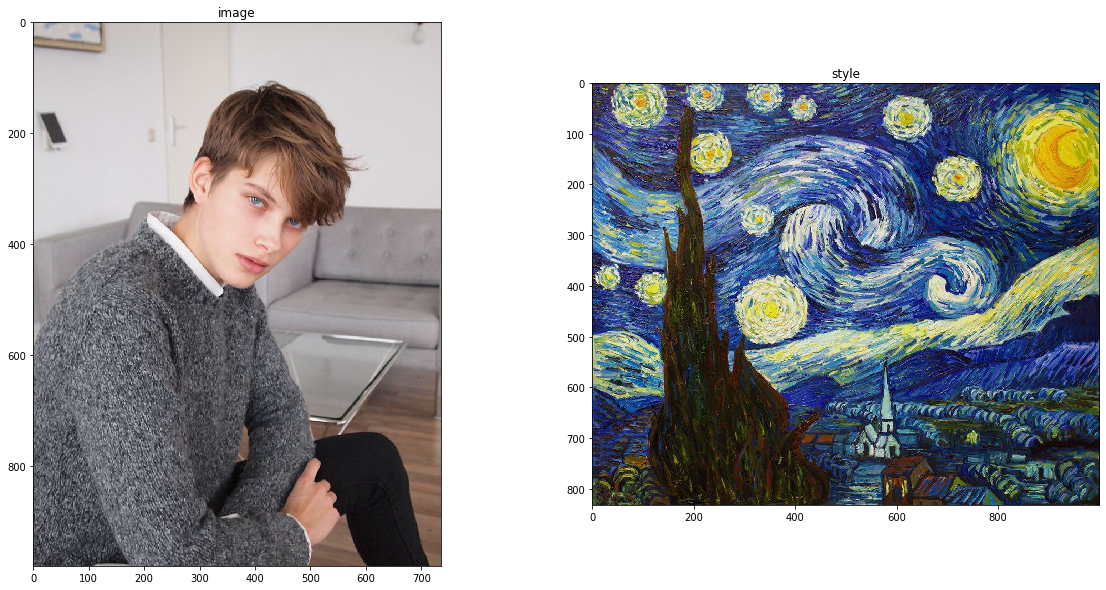

In [2]:
content = plt.imread('images/girl.jpg')
style = plt.imread('images/style.jpg')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(content)
ax1.set_title('image')
ax2.imshow(style)
ax2.set_title('style')
plt.show()

In [3]:
def load_image(image):
    image = plt.imread(image)
    img = tf.image.convert_image_dtype(image, tf.float32)
    img = tf.image.resize(img, [400, 400])
    
    img = img[tf.newaxis, :]
    return img

In [4]:
content = load_image('images/girl.jpg')
style = load_image('images/style.jpg')

content.shape, style.shape

(TensorShape([1, 400, 400, 3]), TensorShape([1, 400, 400, 3]))

In [5]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

In [6]:
_ = [layer.name for layer in vgg.layers]
_

['input_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [7]:
content_layers = ['block4_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [8]:
def mini_model(layer_names, model):
    outputs = [model.get_layer(name).output for name in layer_names]
    
    model = Model([vgg.input], outputs)
    return model

## MACIERZ GRAMA
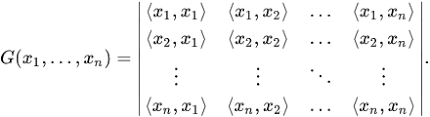

In [9]:
def gram_matrix(tensor):
    temp = tensor
    temp = tf.squeeze(temp)
    fun = tf.reshape(temp, [temp.shape[2], temp.shape[0]*temp.shape[1]])
    result = tf.matmul(temp, temp, transpose_b=True)
    gram = tf.expand_dims(result, axis=0)
    return gram

In [10]:
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

class Custom_Style_Model(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(Custom_Style_Model, self).__init__()
        self.vgg = mini_model(style_layers + content_layers, vgg)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        # scale back the pixel values
        inputs = inputs*255.0
        # preprocessing to vgg stats
        preprocessed_input = preprocess_input(inputs)
        # pass through the mini network
        outputs = self.vgg(preprocessed_input)
        # segregate style n content representations
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])
        # calculate gram matrix for each layer
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        
        # assign content representation and gram matrix in a layer by layer fashion in dicts
        content_dict = {content_name:value
                      for content_name, value
                      in zip(self.content_layers, content_outputs)}
        
        style_dict = {style_name:value 
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}
        
        return {'content':content_dict, 'style':style_dict}

In [11]:
extractor = Custom_Style_Model(style_layers, content_layers)
style_targets = extractor(style)['style']
content_targets = extractor(content)['content']

In [12]:
opt = tf.keras.optimizers.Adam(lr=0.02)

In [13]:
style_weight = 100
content_weight = 10

style_weights = {'block1_conv1':1.0,
                 'block2_conv1':0.8,
                 'block3_conv1':0.5,
                 'block4_conv1':0.3,
                 'block5_conv1':0.1}

In [16]:
def total_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                             for name in style_outputs.keys()])
    
    # normalization
    style_loss *= style_weight / num_style_layers
    
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                            for name in content_outputs.keys()])
    
    # normalize
    content_loss *= content_weight
    loss = style_loss + content_loss
    return loss

In [17]:
def train_step(image):
    with tf.GradientTape() as tape:
        # extract the fatures
        outputs = extractor(image)
        #calculate loss
        loss = total_loss(outputs)
    #determine the gradients of the loss function
    grad = tape.gradient(loss, image)
    # update the pixels
    opt.apply_gradients([(grad, image)])
    # clip the pixel values that fall outside the range of [0, 1]
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

In [18]:
target_img = tf.Variable(content)

In [ ]:
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(target_img)
    plt.imshow(np.squeeze(target_img.read_value(), 0))
    plt.title(f"Train step: {step}")
    plt.show()

In [ ]:
# scr https://www.datacamp.com/community/tutorials/implementing-neural-style-transfer-using-tensorflow